# Homework 4 Solutions

Computational Physics Fall 2025 

# Problem 1: Taylor Series Errors

## Part A
Let $a: \mathbb{R}\to \mathbb{R}$ be a smooth function. Then it admits a Taylor series 
$$
a(x) = \sum_{n=0}^\infty \frac{a^{(n)}(0)}{n!} x^n 
$$
In our case, the two taylor series are given by
$$
\begin{align*}
a(x) = \exp(-3x) = \sum_{n=0}^{\infty} \frac{(-3x)^{n}}{n!} && b(x) = \sin(5x) = \sum_{n=0}^{\infty} \frac{(-1)^{n} (5x)^{2n+1}}{(2n+1)!}
\end{align*} 
$$
Let's denote the coefficients $a_n,b_n$ to simplify this a bit
$$
\begin{align*}
a_n = \frac{(-3)^{n}}{n!} && b_n =  \frac{(-1)^{n} (5)^{2n+1}}{(2n+1)!}
\end{align*} 
$$

For the recursive case we have that
$$
r^a_n = \frac{a_{n}}{a_{n-1}} = \frac{(-3)^{n}(n-1)!}{(-3)^{n-1} (n)!} = -\frac{3}{n}
$$
and for the other series
$$
r^b_n = \frac{b_n}{b_{n-1}} = \frac{(-1)^n (5)^{2n+1} (2n - 1)!}{(-1)^{n-1} (5)^{2n-1} (2n + 1)!} = -\frac{25}{(4n^2+2n)}
$$

In [1]:
import numpy as np
from math import factorial as fac

# Create a factorial that handles overflow
def factorial(n: int):
    try:
        return np.float32(fac(n))
    except OverflowError:
        return np.float32('inf')
        

# Non-recursive term calculation
def a_direct(x:np.float32, N:int=10) -> np.float32:
    try:
        return sum([np.float32((-3*x)**n/factorial(n)) for n in range(N+1)])
    except OverflowError:
        return np.float32('inf')

# Non-recursive term calculation
def b_direct(x:np.float32, N:int=10) -> np.float32:
    try:
        return sum([np.float32((-1)**n * (5*x)**(2*n+1)/fac(2*n+1)) for n in range(N+1)])
    except OverflowError:
        return np.float32('inf')

def f_direct(x:np.float32, N:int=10) -> np.float32:
    return a_direct(x,2*N) * b_direct(x,N)

# Recursive calculation
def a_recurs(x:np.float32, N:int=10) -> np.float32:

    terms = np.array([1]*(N+1), dtype=np.float32)

    for n in range(1,N+1):
        terms[n] = -3*terms[n-1]*x/n
    
    return np.sum(terms)

# Recursive calculation
def b_recurs(x:np.float32, N:int=10) -> np.float32:

    terms = np.array([5*x]*(N+1), dtype=np.float32)

    for n in range(1,N+1):
        terms[n] = -25*terms[n-1]*x*x/(2*n*(2*n + 1))
    
    return np.sum(terms)

def f_recurs(x:np.float32, N:int=10) -> np.float32:
    return a_recurs(x,2*N) * b_recurs(x,N)

def f(x):
    return np.exp(-3*x) * np.sin(5*x)

## Part B

Let's plot!

/tmp/ipykernel_31062/1662014118.py:7: RuntimeWarning: overflow encountered in cast
  return np.float32(fac(n))


(0.0, 119.0)

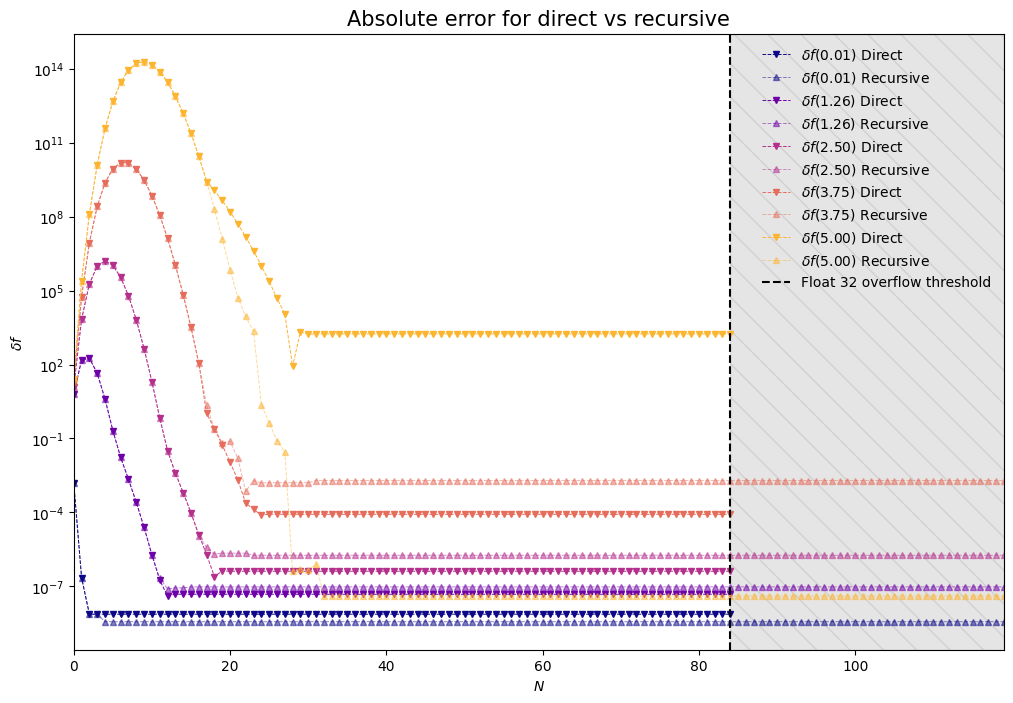

In [2]:
import matplotlib.pyplot as plt

# Let's first calculate the errors
X_range         = np.linspace(0.01, 5, 5)
colors          = {x:color for x,color in zip(X_range,plt.cm.plasma(X_range/(1.2*max(X_range))))}
N_range         = np.arange(120) 
direct_error    = {x:[abs(f_direct(x, n) - f(x)) for n in N_range] for x in X_range}
recurs_error    = {x:[abs(f_recurs(x, n) - f(x)) for n in N_range] for x in X_range}


# PLOTTING ---------------------------------------------------
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)

# Add the plot elements
for x in X_range:
    ax.plot(N_range, direct_error[x], color=colors[x], ms=4, lw=0.7, ls='--', marker= "v", alpha=1.0, label=rf"$\delta f(%.2f)$"%x + " Direct")
    ax.plot(N_range, recurs_error[x], color=colors[x], ms=4, lw=0.7, ls='--', marker= "^", alpha=0.5, label=rf"$\delta f(%.2f)$"%x + " Recursive")

# Plot the range where the values disappear
threshold = 84
ax.axvline(threshold, c = 'k', ls = '--', label="Float 32 overflow threshold")
ax.axvspan(threshold, N_range[-1], color = 'gray', alpha = 0.2, hatch="\\")

# Some prettification steps
ax.set_title("Absolute error for direct vs recursive",fontsize=15)
ax.legend(frameon=False, loc='upper right')
ax.set_ylabel(r'$\delta f$')
ax.set_xlabel(r'$N$')
ax.set_yscale('log')
ax.set_xlim(N_range[0],N_range[-1])

## Part C

As we can see in the plots above, there is a region for which the error flattens, because we have achieved the closest approximation we could using the floats, beyond which we just add zeros.

We can also see that the optimal value of $N$ depends on $x$, which is not at all unexpected. One way to do this is to use curve fitting, but just for fun, let's see an alternative to that.

We see that at some point we have to add a term that is lower than the smallest number a 32-float can store. We have seen that this is around when the term $f_n x^{n} \approx \epsilon = 2^{-19}$. Therefore, let's calculate this. 

For the function $a(x)$ that happens when (using Stirling's approximation)
$$
\log \epsilon = \log(|a_n x^n|) = n \log|x| + \log 3 + n\log n \iff n \log \frac{|x|}{n} = \log \frac{\epsilon}{3} 
$$

So we could start solving this equation graphically for both terms and take the minimum, which I think is super fun to think about.

# Problem 2

We want to derive the error in Simpson's rule for computing 1D integrals. Simpson's rule is simply a better way to approximate integrals other than using the fundamental theorem of calculus in small ranges. In some sense, it says that the integral of some $f(x)$ in $x \in [x-h,x+h]$ is given by
$$
\int_{x-h}^{x+h} f(x) dx = \frac{h}{3} \left[ f(x-h) + 4f(x) + f(x+h) \right] - \frac{1}{90}h^{5} f^{(4)}(\xi),
$$
for some $\xi \in [x-h,x+h]$, where the second term is called the "error term". To derive this we do the following.
$$
f(y) = f(x) + f'(x)(y-x)  + \frac{1}{2} f''(x)(y-x)^2 + \frac{1}{6} f^{(3)} (x)(y-x)^3 + \frac{1}{24} f^{(4)}(x)(y-x)^4  + \mathcal{O}((y-x)^{5})
$$
Now we can evaluate the integral (knowing that the odd terms will cancel) to be 
$$
\int_{x-h}^{x+h} f(y) dy = 2hf(x) + \frac{h^3}{3} f''(x) + \frac{h^5}{60} f^{(4)}(x) + \mathcal{O}(h^{7}).
$$
Using the Taylor series we have derived, we can express $f(x\pm h)$ in terms of $f(x) to get rid of some terms like so
$$
f(x\pm h) = f(x) \pm f'(x)h + \frac{1}{2} f''(x)h^2 \pm \frac{1}{6} f^{(3)} (x)h^3 + \frac{1}{24} f^{(4)}(x)h^4  + \mathcal{O}(h^{5}).
$$
So let's use that to get rid of the second derivative terms in our integral. Summing the two, we have that
$$
f(x+h) + f(x-h) = 2 f(x) + f''(x) h^2 + \frac{1}{12} f^{(4)}(x)h^{4} + \mathcal{O}(h^{5}). 
$$
Plugging this into our integral we get that 
$$
\int_{x-h}^{x+h} f(y) dy = \frac{h}{3} \left[ f(x-h) + 4f(x) + f(x+h) \right] - \frac{1}{90}h^{5} f^{(4)}(x) + \mathcal{O}(h^{7}).
$$
Using taylor's Theorem we have that for evrey $x \in [x-h,x+h]$ there must exist a $\xi \in [x-h,x+h]$ such that
$$
- \frac{1}{90}h^{5} f^{(4)}(x) + \mathcal{O}(h^{7}) = - \frac{1}{90}h^{5} f^{(4)}(\xi),
$$
and therefore we derived the error term!

# Problem 3

## Part A

Analytically we calculate the integral like so
$$
\int_{0}^1 (-4x^4 + 7x^3 - 2x^2 + 3)dx = -\frac{4}{5} + \frac{7}{4} - \frac{2}{3} + 3 = \frac{197}{60}
$$

Using the trapezoid rule we have that
$$
\int_{0}^1 f(X) dx = \frac{f(1) + f(0)}{2} = \frac{-4 + 7 - 2 + 3}{2} = 2
$$

Using the Simpson's rule we have that
$$
\int_{0}^1 f(X) dx = \frac{1}{6} \left[ f(0) + 4f(1/2) + f(1) \right] = \frac{ \frac{25}{2} + 4}{6} = \frac{33}{12}
$$

## Part B
The error in the trapezoid rule is given by
$$
\epsilon = \int_{x-h}^{x+h} f(y)dy - \left[f(x+h) + f(x-h)\right] h.
$$
We can use the taylor expansions we found before to obtain that
$$
\begin{align*}
\epsilon &=  2f(x)h + \frac{1}{3} f''(x) h^3 - 2f(x)h - f''(x) h^2 + \mathcal{O}(h^{3})\\
&= - \frac{2}{3} f''(x) h^3 + \mathcal{O}(h^{3})\\
&= - \frac{2}{3} f''(\xi) h^3,
\end{align*} 
$$
for some appropriately chosen $\xi \in [x-h,x+h]$. If we fix $\xi=1/2$ for this problem we have that the theoretical error we calculate is
$$
\epsilon = \frac{2}{3}(-96 \xi^2 + 42 \xi - 4) = -\frac{14}{3}.
$$
However, the true error is 
$$
\epsilon_{\text{true}} = \frac{197}{60} - 2 = \frac{77}{60}.
$$
The reason why they are different is because we didn't pick the right value for $\xi$. In principle there is one that will give us exactly $\epsilon_{\text{true}}$ but without hindsight we can't really know which one.

For Simpson's rule, the error is 
$$
\begin{align*}
\epsilon = - \frac{1}{90}h^{5} f^{(4)}(1/2) = \frac{1}{30} && \epsilon_{\text{true}} = \frac{197}{60} - \frac{33}{12} = \frac{16}{30}
\end{align*} 
$$


# Problem 4

## Part A
To calculate the total energy we need to integrate this over the range of frequencies, therefore we have that
$$
\begin{align*}
W &= \int_{0}^\infty I(\omega) d\omega\\
&= \frac{\hbar}{4\pi^2 c^2}\int_{0}^{\infty} \frac{\omega^3}{e^{\frac{\hbar \omega}{kT}} - 1} d\omega\\
&= \frac{k^4 T^4}{4 \pi^2 c^2 \hbar^3} \int_{0}^\infty \frac{x^3}{e^{x} - 1} dx,
\end{align*} 
$$
where we have made the coordinate change $x = \frac{\hbar \omega}{kT}$.

# Part B
Let's write a program that evaluates this integral using Simpson's rule and some discretization $h>0$ by capping off the value at same large $X>0$. 

In [3]:
from typing import Callable

# Define the integrand
f = lambda x: x**3/(np.exp(x) - 1)

# A function that uses Simpson's rule to calculate the integral of f between some range
def simp(f:Callable, a:float, b:float, h:float = 0.1) -> float:
    assert(a<b)             # make sure a < b
    N = int((b - a)/(2*h))  # the number of steps we need given an h
    return sum([(f(a + 2*h*i) + 4*f(a + 2*h*i + h) + f(a + 2*h*(i+1)))*h/3 for i in range(N)])

print("The integral is approximated as: %.3f"%simp(f,1e-5,1e2,1e-2))

The integral is approximated as: 6.494


# Part C

To calculate the stefan bolzmann constant we have that if we call our integral
$$
C = \int_0^\infty \frac{x^3}{e^{x} - 1},
$$
then from $W=\sigma T^4$ we have that
$$
\begin{align*}
\sigma = \frac{W}{T^4} =  \frac{k^4 C}{4 \pi^2 c^2 \hbar^3} = 5.67 \times 10^{-8} \frac{W}{m^2 K^4}
\end{align*} 
$$

In [4]:
# Get our constants
from scipy.constants import hbar, k, c, pi

# Calculate C
C = simp(f,1e-5,1e2,1e-2)

# Calculate Bolzmann constant
s = (k/hbar)**4 * hbar/c**2 /(4 * pi**2) * C

print("Stefan Bolzmann constant is approximated as: %.3e W/m^2 K^4"%s)

Stefan Bolzmann constant is approximated as: 5.670e-08 W/m^2 K^4
